In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [2]:
# Loading the Iris dataset

iris = load_iris()
X = iris.data[:, 2:] # Selecting the two last columns
y = iris.target

target_names = iris.target_names
features_names = iris.feature_names

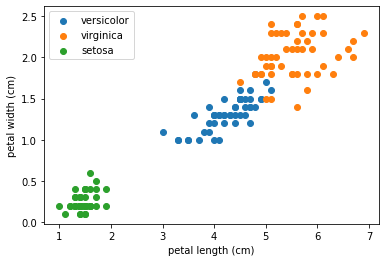

In [3]:
# Plotting

plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label=target_names[1])
plt.scatter(X[y == 2][:,0], X[y == 2][:,1], label=target_names[2])
plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label=target_names[0])
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.legend()
plt.show()

In [4]:
class FrankTreeClassifier:
    def __init__(self):
        pass
    
    @staticmethod
    def partition(y, return_label=False):
        label, partition = np.unique(y, return_counts=True)
        sorted_label, sorted_partition = (np.flip(label[np.argsort(partition)]), 
                                          np.flip(partition[np.argsort(partition)]))
        if return_label == True:
            return sorted_label, sorted_partition
        else:
            return sorted_partition
    
    @staticmethod
    def gini(partition):
        partition_sum = partition.sum()
        g = 1 - ((partition/partition_sum)**2).sum()
        return g
    
    
    @staticmethod
    def split(X, y, col, thr, return_X=False):
        y_true = y[X[:, col] >= thr]
        y_false = y[X[:, col] < thr]
        if return_X == False:
            return y_true, y_false
        else:
            X_true = X[X[:, col] >= thr]
            X_false = X[X[:, col] < thr]
            return X_true, X_false, y_true, y_false
        
    def weighted_mean_gini(self, partition_true, partition_false):
        gini_true = self.gini(partition_true)
        gini_false = self.gini(partition_false)
        partition_true_sum = partition_true.sum()
        partition_false_sum = partition_false.sum()
        partition_total = partition_true_sum + partition_false_sum
        wmean = ((gini_true*partition_true_sum) + (gini_false*partition_false_sum)) / partition_total
        return wmean
    
    def make_tree(self, X, y):
        
        gini_old = self.gini(y)
        information_gain_array = np.zeros(X.shape)
        
        # Search for best information gain
        for row in range(X.shape[0]):
            for col in range(X.shape[1]):
                thr = X[row,col]
                y_true, y_false = self.split(X, y, col, thr, return_X=False)
                partition_true, partition_false = self.partition(y_true), self.partition(y_false)
                gini_new = self.weighted_mean_gini(partition_true, partition_false)
                information_gain = gini_old - gini_new
                information_gain_array[row,col] = information_gain
        
        flat_index = information_gain_array.argmax()
        max_gain_index = np.unravel_index(flat_index, information_gain_array.shape)
        
        # Question
        col = max_gain_index[1]
        thr = X[max_gain_index]
        
        # Arrays
        X_true, X_false, y_true, y_false = self.split(X, y, col, thr, return_X=True)
        splited_arrays = [[X_true, y_true], [X_false, y_false]] 
        
        # Predictions
        true_pred = self.partition(y_true, return_label=True)[0][0]
        false_pred = self.partition(y_false, return_label=True)[0][0]
        label_pred = [true_pred, false_pred]
        
        # Information gain
        partition_true, partition_false = self.partition(y_true), self.partition(y_false)
        gini_new = self.weighted_mean_gini(partition_true, partition_false)
        information_gain = gini_old - gini_new
        
        return col, thr, splited_arrays, label_pred, information_gain
        
    
    def fit(self, X, y):
        # This is only a depth two tree, and the false split was not implemented
        
        self.X, self.y = X, y
        self.questions_list = []
        
        # Depth one split
        col, thr, splited_arrays, label_pred, information_gain = self.make_tree(self.X, self.y) 
        self.questions_list.append([col, thr, label_pred])
        
        # Depth two true split
        self.X, self.y = splited_arrays[0]
        col, thr, splited_arrays, label_pred, information_gain = self.make_tree(self.X, self.y) 
        self.questions_list.append([col, thr, label_pred])
        
        # There's no depth two false split to be done on this data
        
    
    def predict(self, X): 
        # This is only a depth two predict without the depth two false split
        
        y_pred = np.zeros(X.shape[0])
        
        for i in range(y_pred.shape[0]):
            if X[i, self.questions_list[0][0]] >= self.questions_list[0][1]:
                if X[i, self.questions_list[1][0]] >= self.questions_list[1][1]:
                     y_pred[i] = self.questions_list[1][2][0]
                else:
                     y_pred[i] = self.questions_list[1][2][1]
            else:
                y_pred[i] = self.questions_list[0][2][1]
        
        return y_pred

In [5]:
tree = FrankTreeClassifier()
tree.fit(X, y)
y_pred = tree.predict(X)
accuracy_score(y, y_pred)

0.96

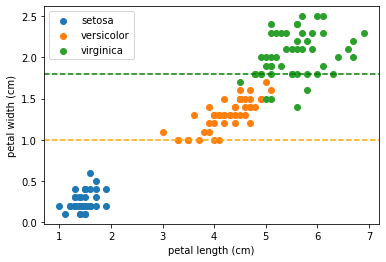

In [6]:
# Plotting decision boundary

plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label=target_names[0])
plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label=target_names[1])
plt.scatter(X[y == 2][:,0], X[y == 2][:,1], label=target_names[2])

plt.axhline(y=tree.questions_list[0][1], c='orange', ls='--')
plt.axhline(y=tree.questions_list[1][1], c='green', ls='--')

plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.legend()
plt.show()

In [7]:
# Comparing with sklearn version. Got the same precision

from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)
y_pred_sklearn = tree_clf.predict(X)

accuracy_score(y, y_pred_sklearn)

0.96

In [8]:
# Also got the same predictions

y_pred_sklearn == y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,